In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from juanfit import SpectrumFit2D
from matplotlib import patches
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, 
                                AutoLocator, MaxNLocator)
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval,\
         ManualInterval, SqrtStretch, AsinhStretch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmasher as cmr
import cmcrameri.cm as cmcm
import astropy.constants as const
from matplotlib.colors import LinearSegmentedColormap
import sunpy
import sunpy.map
import astropy.units as u
import sunkit_image.radial as radial
from sunkit_image.utils import equally_spaced_bins
from astropy.wcs import WCS
from sunpy.coordinates import Helioprojective
from astropy.coordinates import SkyCoord, AltAz, EarthLocation

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1)):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                        facecolor="none",alpha=0.6,ls="--")

In [3]:
FeX_6374_file = "../../sav/AWSoM/syn_fit/box_run0040_run01_75_5th_spm/spm_phx_7_n0115001.sav"
FeXIV_5303_file = "../../sav/AWSoM/syn_fit/box_run0040_run01_75_5th_spm/spm_phx_8_n0115001.sav"

In [4]:
FeXIV_5303_idlsav = readsav(FeXIV_5303_file)
FeXIV_5303_wvl = FeXIV_5303_idlsav["x"][2,:,0,0]
FeXIV_5303_x_mesh = FeXIV_5303_idlsav["x"][0,0,:,:]
FeXIV_5303_y_mesh = FeXIV_5303_idlsav["x"][1,0,:,:]
FeXIV_5303_profiles = FeXIV_5303_idlsav["w"]

In [5]:
FeXIV_5303_profiles.shape

(25, 253, 211)

In [6]:
mask_disk = np.where(np.sqrt(FeXIV_5303_x_mesh**2 + FeXIV_5303_y_mesh**2) < 1.03)

In [7]:
FeXIV_int_sum = np.sum(FeXIV_5303_profiles,axis=0)*0.25
FeXIV_int_sum[mask_disk] = np.nan

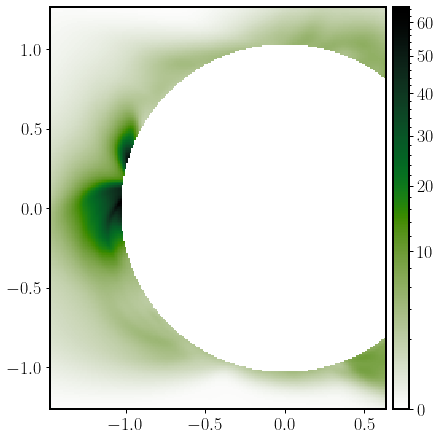

In [8]:
fig, ax = plt.subplots(figsize=(7,6),constrained_layout=True)

FeXIV_norm = ImageNormalize(data=FeXIV_int_sum,stretch=SqrtStretch(),vmin=0)
im = ax.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_int_sum,
              rasterized=True,cmap=cmr.jungle_r,shading="auto",norm=FeXIV_norm)

plot_colorbar(im,ax,width="5%",fontsize=18)

ax.set_aspect(1)
ax.tick_params(labelsize=18)

In [9]:
FeXIV_fitmodel = SpectrumFit2D(np.transpose(FeXIV_5303_profiles,(1,2,0)),wvl=FeXIV_5303_wvl,line_number=1,
                               line_wvl_init=5304.47,int_max_init=10,fwhm_init=1)
FeXIV_fitmodel.run_lse_mp(ncpu=4,prev_init=False)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
 

In [10]:
FeXIV_lambd0_vaccum = 5304.4771

In [11]:
FeXIV_int_fit = FeXIV_fitmodel.int_total_fit[:,:,0]
FeXIV_int_fit[mask_disk] = np.nan
FeXIV_wvl_fit = FeXIV_fitmodel.line_wvl_fit[:,:,0]
FeXIV_wvl_fit[mask_disk] = np.nan
FeXIV_vlos_fit = -(FeXIV_wvl_fit - FeXIV_lambd0_vaccum)/FeXIV_lambd0_vaccum*const.c.cgs.value/1e5
FeXIV_fwhm_fit = FeXIV_fitmodel.fwhm_fit[:,:,0]
FeXIV_fwhm_fit[mask_disk] = np.nan
FeXIV_veff_fit = FeXIV_fwhm_fit/FeXIV_lambd0_vaccum/np.sqrt(4*np.log(2))*const.c.cgs.value/1e5

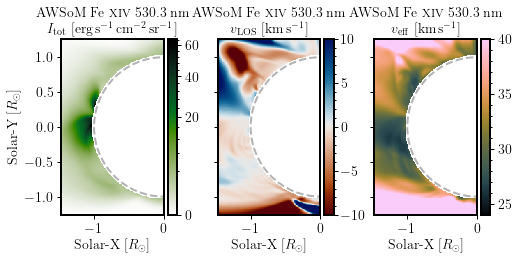

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(7,3.5),constrained_layout=True)

FeXIV_int_norm = ImageNormalize(data=FeXIV_int_fit,stretch=SqrtStretch(),vmin=0)
im1 = ax1.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_int_fit,
              rasterized=True,cmap=cmr.jungle_r,shading="auto",norm=FeXIV_int_norm)
plot_colorbar(im1,ax1,width="9%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))

ax1.set_title(r"AWSoM Fe \textsc{xiv} 530.3 nm" + "\n" + \
            r"$I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=14)


im2 = ax2.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_vlos_fit,
              rasterized=True,cmap=cmcm.vik_r,shading="auto",vmin=-10,vmax=10)
plot_colorbar(im2,ax2,width="9%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))
ax2.set_title(r"AWSoM Fe \textsc{xiv} 530.3 nm" + "\n" + \
            r"$v_{\rm LOS}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
ax2.tick_params(labelleft=False)

im3 = ax3.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_veff_fit,
              rasterized=True,cmap=cmcm.batlowK,shading="auto",vmin=24,vmax=40)
plot_colorbar(im3,ax3,width="9%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))
ax3.set_title(r"AWSoM Fe \textsc{xiv} 530.3 nm" + "\n" + \
                r"$v_{\rm eff}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
ax3.tick_params(labelleft=False)
ax1.set_ylabel(r"Solar-Y $[R_\odot]$",fontsize=14)

for ax_ in (ax1,ax2,ax3):
    ax_.set_xlim(right=0)
    ax_xlim = ax_.get_xlim()
    ax_ylim = ax_.get_ylim()
    ax_.add_patch(create_limb_circle(1))
    ax_.set_xlim(ax_xlim)
    ax_.set_ylim(ax_ylim)
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlabel(r"Solar-X $[R_\odot]$",fontsize=14)
    


In [13]:
FeX_6374_idlsav = readsav(FeX_6374_file)
FeX_6374_wvl = FeX_6374_idlsav["x"][2,:,0,0]
FeX_6374_x_mesh = FeX_6374_idlsav["x"][0,0,:,:]
FeX_6374_y_mesh = FeX_6374_idlsav["x"][1,0,:,:]
FeX_6374_profiles = FeX_6374_idlsav["w"]

In [14]:
FeX_fitmodel = SpectrumFit2D(np.transpose(FeX_6374_profiles,(1,2,0)),wvl=FeX_6374_wvl,line_number=1,
                               line_wvl_init=6376.2900,int_max_init=10,fwhm_init=1)
FeX_fitmodel.run_lse_mp(ncpu=4,prev_init=False)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")
/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
 

In [15]:
FeX_lambd0_vaccum = 6376.2900

In [16]:
FeX_int_fit = FeX_fitmodel.int_total_fit[:,:,0]
FeX_int_fit[mask_disk] = np.nan
FeX_wvl_fit = FeX_fitmodel.line_wvl_fit[:,:,0]
FeX_wvl_fit[mask_disk] = np.nan
FeX_vlos_fit = -(FeX_wvl_fit - FeX_lambd0_vaccum)/FeX_lambd0_vaccum*const.c.cgs.value/1e5
FeX_fwhm_fit = FeX_fitmodel.fwhm_fit[:,:,0]
FeX_fwhm_fit[mask_disk] = np.nan
FeX_veff_fit = FeX_fwhm_fit/FeX_lambd0_vaccum/np.sqrt(4*np.log(2))*const.c.cgs.value/1e5

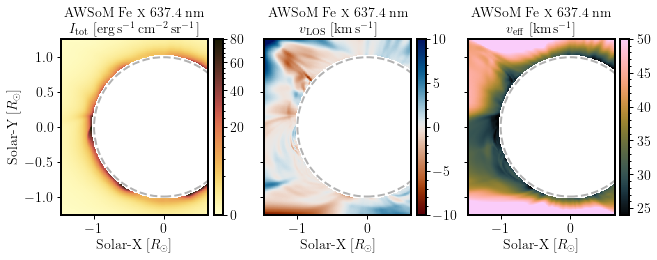

In [17]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(9,3.5),constrained_layout=True)

FeX_int_norm = ImageNormalize(data=FeX_int_fit,stretch=SqrtStretch(),vmin=0,vmax=80)
im1 = ax1.pcolormesh(FeX_6374_x_mesh,FeX_6374_y_mesh,FeX_int_fit,
              rasterized=True,cmap=cmcm.lajolla,shading="auto",norm=FeX_int_norm)
plot_colorbar(im1,ax1,width="6%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))

ax1.set_title(r"AWSoM Fe \textsc{x} 637.4 nm" + "\n" + \
            r"$I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}$",fontsize=14)


im2 = ax2.pcolormesh(FeX_6374_x_mesh,FeX_6374_y_mesh,FeX_vlos_fit,
              rasterized=True,cmap=cmcm.vik_r,shading="auto",vmin=-10,vmax=10)
plot_colorbar(im2,ax2,width="6%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))
ax2.set_title(r"AWSoM Fe \textsc{x} 637.4 nm" + "\n" + \
            r"$v_{\rm LOS}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
ax2.tick_params(labelleft=False)

im3 = ax3.pcolormesh(FeX_6374_x_mesh,FeX_6374_y_mesh,FeX_veff_fit,
              rasterized=True,cmap=cmcm.batlowK,shading="auto",vmin=24,vmax=50)
plot_colorbar(im3,ax3,width="6%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))
ax3.set_title(r"AWSoM Fe \textsc{x} 637.4 nm" + "\n" + \
                r"$v_{\rm eff}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
ax3.tick_params(labelleft=False)
ax1.set_ylabel(r"Solar-Y $[R_\odot]$",fontsize=14)

for ax_ in (ax1,ax2,ax3):
    ax_xlim = ax_.get_xlim()
    ax_ylim = ax_.get_ylim()
    ax_.add_patch(create_limb_circle(1))
    ax_.set_xlim(ax_xlim)
    ax_.set_ylim(ax_ylim)
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlabel(r"Solar-X $[R_\odot]$",fontsize=14)


In [18]:
white_light_file_mu042 = "../../sav/AWSoM/syn_fit/box_run0040_run01_75_5th_spm/awsom_wl_mu042.sav"
white_light_idlsave_mu042 = readsav(white_light_file_mu042)

In [19]:
tB_mu042 = white_light_idlsave_mu042["w"][0,:,:]
pB_mu042 = white_light_idlsave_mu042["w"][1,:,:]

In [20]:
myWL_cmapdict = {"red":[[0,47/255,47/255],
                        [1,1,1]],
                "green":[[0,68/255,68/255],
                        [1,1,1]],
                "blue":[[0,98/255,98/255],
                        [1,1,1]]}
myWL_cmap = LinearSegmentedColormap("myWL",segmentdata=myWL_cmapdict, N=256)

In [21]:
tB_mu042.shape

(1001, 1001)

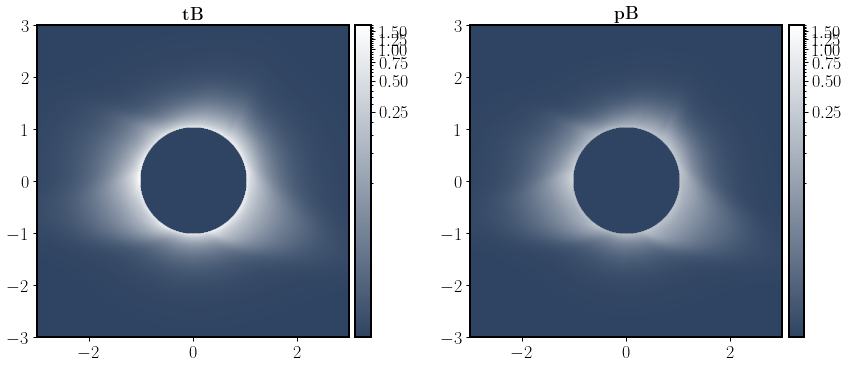

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5),constrained_layout=True)
tB_mu042_norm = ImageNormalize(data=tB_mu042[200:-200,200:-200], vmin=tB_mu042[200,200],stretch=LogStretch())
im1 = ax1.imshow(tB_mu042[200:-200,200:-200],origin="lower",norm=tB_mu042_norm,cmap=myWL_cmap,
                extent=[-3.005,3.005,-3.005,3.005])
plot_colorbar(im=im1,ax=ax1,width="5%",fontsize=18)
ax1.set_title(r"\textbf{tB}",fontsize=18)

pB_mu042_norm = ImageNormalize(data=pB_mu042[200:-200,200:-200], vmin=pB_mu042[200,200],stretch=LogStretch())
im2 = ax2.imshow(pB_mu042[200:-200,200:-200],origin="lower",norm=tB_mu042_norm,cmap=myWL_cmap,
                extent=[-3.005,3.005,-3.005,3.005])
plot_colorbar(im=im2,ax=ax2,width="5%",fontsize=18)
ax2.set_title(r"\textbf{pB}",fontsize=18)

for ax_ in (ax1,ax2):
    ax_.tick_params(labelsize=18)

In [23]:
radial_bin_edges = equally_spaced_bins(inner_value=1.03,outer_value=3,nbins=100)*u.Rsun

In [24]:
pB_mu042[200:-200,200:-200].shape

(601, 601)

In [25]:
time = '2017-08-21 17:46'
obs_location = EarthLocation(lat=42*u.deg+18.585*u.arcmin, lon=-(104*u.deg+47.206*u.arcmin),height=1406*u.m)
obs_location.to_geocentric()

(<Quantity -1205912.72068739 m>,
 <Quantity -4568468.5902201 m>,
 <Quantity 4272056.46613378 m>)

In [26]:
awsom_wcs_dict = {
    "CTYPE1": "HPLN-TAN",
    "CUNIT1": "arcsec",
    "CDELT1": 0.01*950.,
    "CRPIX1": 301,
    "NAXIS1": 601,
    "CRVAL1": 0.,
    "CTYPE2": "HPLT-TAN",
    "CUNIT2": "arcsec",
    "CDELT2": 0.01*950.,
    "CRPIX2": 301,
    "NAXIS2": 601,
    "CRVAL2": 0.,
    "DATE-OBS": "2017-08-21T17:46:00",
    "OBSGEO-X": -1205912.72068739,
    "OBSGEO-Y": -4568468.5902201,
    "OBSGEO-Z": 4272056.46613378,
}
awsom_wcs = WCS(awsom_wcs_dict)

Set OBSGEO-B to    42.309750 from OBSGEO-[XYZ].
Set OBSGEO-H to     1402.990 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [27]:
tB_mu042_smap = sunpy.map.Map((tB_mu042[200:-200,200:-200],awsom_wcs))

In [28]:
tB_mu042_smap.pixel_to_world(100*u.pix,100*u.pix)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


<SkyCoord (Helioprojective: obstime=2017-08-21T17:46:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21T17:46:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 6.92862651, 1.51324815e+11)>): (Tx, Ty) in arcsec
    (-1899.94626377, -1899.8656673)>

In [29]:
order = 20
attenuation_coefficients = radial.set_attenuation_coefficients(order)
tB_mu042_filtered = radial.fnrgf(tB_mu042_smap, radial_bin_edges, order, attenuation_coefficients, application_radius=1.04*u.Rsun)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


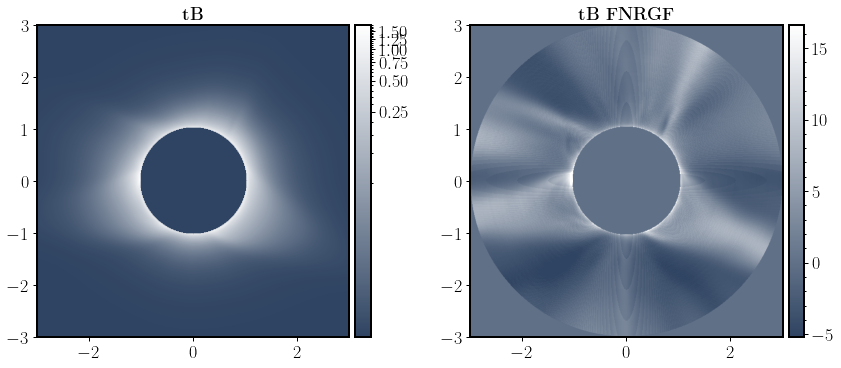

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5),constrained_layout=True)
tB_mu042_norm = ImageNormalize(data=tB_mu042[200:-200,200:-200], vmin=tB_mu042[200,200],stretch=LogStretch())
im1 = ax1.imshow(tB_mu042[200:-200,200:-200],origin="lower",norm=tB_mu042_norm,cmap=myWL_cmap,
                extent=[-3.005,3.005,-3.005,3.005])
plot_colorbar(im=im1,ax=ax1,width="5%",fontsize=18)
ax1.set_title(r"\textbf{tB}",fontsize=18)

tB_mu042_filtered_norm = ImageNormalize(data=tB_mu042_filtered.data,interval=ZScaleInterval())
im2 = ax2.imshow(tB_mu042_filtered.data,origin="lower",norm=tB_mu042_filtered_norm,cmap=myWL_cmap,
                extent=[-3.005,3.005,-3.005,3.005])
plot_colorbar(im=im2,ax=ax2,width="5%",fontsize=18)
ax2.set_title(r"\textbf{tB FNRGF}",fontsize=18)

for ax_ in (ax1,ax2):
    ax_.tick_params(labelsize=18)

(array([2.20044e+05, 3.13780e+04, 1.26300e+03, 2.22000e+02, 3.30000e+01,
        1.40000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

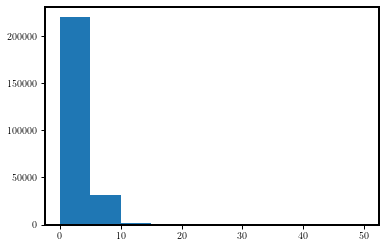

In [31]:
plt.hist(tB_mu042_filtered.data.flatten(),range=(0,50))

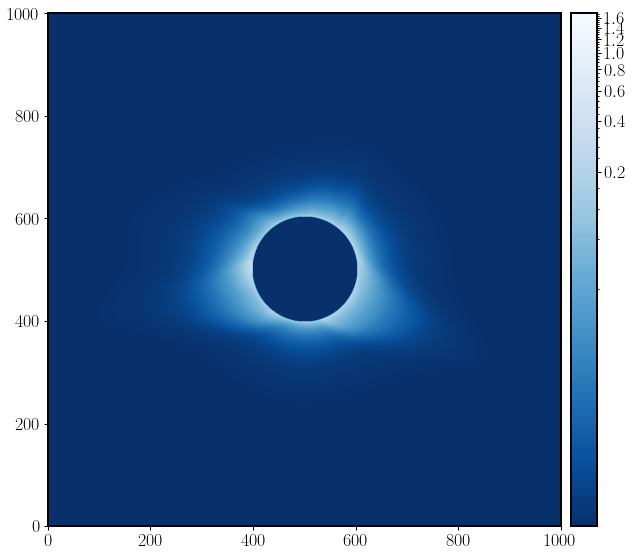

In [32]:
fig, ax = plt.subplots(figsize=(8,8),constrained_layout=True)
pB_mu042_norm = ImageNormalize(data=pB_mu042, stretch=LogStretch())
im = ax.imshow(pB_mu042,origin="lower",norm=tB_mu042_norm,cmap="Blues_r")
plot_colorbar(im=im,ax=ax,width="5%",fontsize=18)
ax.tick_params(labelsize=18)

In [33]:
tB_mu042_crop = tB_mu042[500-126:500+127,500-147:500+64]

(array([4.6876e+04, 3.4350e+03, 1.4780e+03, 8.1700e+02, 4.6500e+02,
        1.7700e+02, 6.9000e+01, 3.6000e+01, 1.7000e+01, 1.3000e+01]),
 array([0.        , 0.17083498, 0.34166997, 0.51250495, 0.68333993,
        0.85417491, 1.0250099 , 1.19584488, 1.36667986, 1.53751484,
        1.70834983]),
 <BarContainer object of 10 artists>)

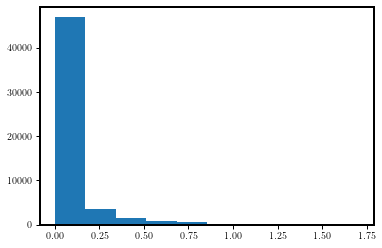

In [34]:
plt.hist(tB_mu042_crop.flatten(),bins=10)

In [35]:
FeXIV_int_cont_ratio = FeXIV_int_fit/tB_mu042_crop

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


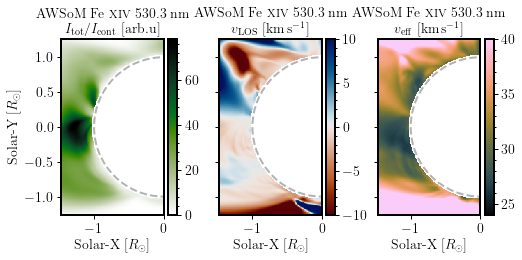

In [36]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(7,3.5),constrained_layout=True)

FeXIV_int_cont_norm = ImageNormalize(data=FeXIV_int_cont_ratio,vmin=0)
im1 = ax1.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_int_cont_ratio,
              rasterized=True,cmap=cmr.jungle_r,shading="auto",norm=FeXIV_int_cont_norm)
plot_colorbar(im1,ax1,width="9%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))

ax1.set_title(r"AWSoM Fe \textsc{xiv} 530.3 nm" + "\n" + \
            r"$I_{\rm tot}/I_{\rm cont}\ \mathrm{[arb.u]}$",fontsize=14)


im2 = ax2.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_vlos_fit,
              rasterized=True,cmap=cmcm.vik_r,shading="auto",vmin=-10,vmax=10)
plot_colorbar(im2,ax2,width="9%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))
ax2.set_title(r"AWSoM Fe \textsc{xiv} 530.3 nm" + "\n" + \
            r"$v_{\rm LOS}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
ax2.tick_params(labelleft=False)

im3 = ax3.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_veff_fit,
              rasterized=True,cmap=cmcm.batlowK,shading="auto",vmin=24,vmax=40)
plot_colorbar(im3,ax3,width="9%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))
ax3.set_title(r"AWSoM Fe \textsc{xiv} 530.3 nm" + "\n" + \
                r"$v_{\rm eff}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
ax3.tick_params(labelleft=False)
ax1.set_ylabel(r"Solar-Y $[R_\odot]$",fontsize=14)

for ax_ in (ax1,ax2,ax3):
    ax_.set_xlim(right=0)
    ax_xlim = ax_.get_xlim()
    ax_ylim = ax_.get_ylim()
    ax_.add_patch(create_limb_circle(1))
    ax_.set_xlim(ax_xlim)
    ax_.set_ylim(ax_ylim)
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlabel(r"Solar-X $[R_\odot]$",fontsize=14)

plt.savefig(fname="../../sav/AWSoM/syn_fit/box_run0040_run01_75_5th_spm/FeXIV.pdf",dpi=300,format="pdf",
            bbox_inches="tight")
    


In [37]:
FeX_int_cont_ratio = FeX_int_fit/tB_mu042_crop

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


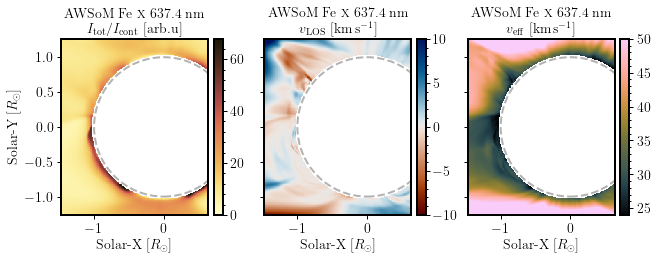

In [39]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(9,3.5),constrained_layout=True)

FeX_int_cont_norm = ImageNormalize(data=FeX_int_cont_ratio,vmin=0)
im1 = ax1.pcolormesh(FeX_6374_x_mesh,FeX_6374_y_mesh,FeX_int_cont_ratio,
              rasterized=True,cmap=cmcm.lajolla,shading="auto",norm=FeX_int_cont_norm)
plot_colorbar(im1,ax1,width="6%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))

ax1.set_title(r"AWSoM Fe \textsc{x} 637.4 nm" + "\n" + \
            r"$I_{\rm tot}/I_{\rm cont}\ \mathrm{[arb.u]}$",fontsize=14)


im2 = ax2.pcolormesh(FeX_6374_x_mesh,FeX_6374_y_mesh,FeX_vlos_fit,
              rasterized=True,cmap=cmcm.vik_r,shading="auto",vmin=-10,vmax=10)
plot_colorbar(im2,ax2,width="6%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))
ax2.set_title(r"AWSoM Fe \textsc{x} 637.4 nm" + "\n" + \
            r"$v_{\rm LOS}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
ax2.tick_params(labelleft=False)

im3 = ax3.pcolormesh(FeX_6374_x_mesh,FeX_6374_y_mesh,FeX_veff_fit,
              rasterized=True,cmap=cmcm.batlowK,shading="auto",vmin=24,vmax=50)
plot_colorbar(im3,ax3,width="6%",fontsize=14,bbox_to_anchor=(1.04, 0., 1, 1))
ax3.set_title(r"AWSoM Fe \textsc{x} 637.4 nm" + "\n" + \
                r"$v_{\rm eff}\ \mathrm{[km\,s^{-1}]}$",fontsize=14)
ax3.tick_params(labelleft=False)
ax1.set_ylabel(r"Solar-Y $[R_\odot]$",fontsize=14)

for ax_ in (ax1,ax2,ax3):
    ax_xlim = ax_.get_xlim()
    ax_ylim = ax_.get_ylim()
    ax_.add_patch(create_limb_circle(1))
    ax_.set_xlim(ax_xlim)
    ax_.set_ylim(ax_ylim)
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.set_xlabel(r"Solar-X $[R_\odot]$",fontsize=14)


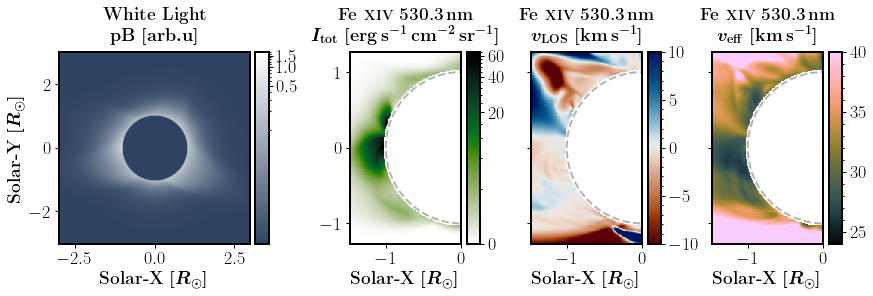

In [80]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(12,4),constrained_layout=True,
                                      gridspec_kw={"width_ratios":[0.9,0.5,0.5,0.5]})

im1 = ax1.imshow(pB_mu042[200:-200,200:-200],origin="lower",norm=tB_mu042_norm,cmap=myWL_cmap,
                extent=[-3.005,3.005,-3.005,3.005])
plot_colorbar(im=im1,ax=ax1,width="7%",fontsize=18,bbox_to_anchor=(1.025, 0., 1, 1))

ax1.set_title(r"\textbf{White Light}" + "\n" + \
            r"$\boldsymbol{\mathrm{pB\ [arb.u]}}$",fontsize=18,
             y=1.03)

FeXIV_int_norm_2 = ImageNormalize(data=FeXIV_int_fit,stretch=AsinhStretch(0.05),vmin=0)
im2 = ax2.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_int_fit,
              rasterized=True,cmap=cmr.jungle_r,shading="auto",norm=FeXIV_int_norm_2)
plot_colorbar(im2,ax2,width="12%",fontsize=18,bbox_to_anchor=(1.05, 0., 1, 1))

ax2.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm}" + "\n" + \
            r"$\boldsymbol{I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}}$",fontsize=18,
             y=1.03)


im3 = ax3.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_vlos_fit,
              rasterized=True,cmap=cmcm.vik_r,shading="auto",vmin=-10,vmax=10)
plot_colorbar(im3,ax3,width="12%",fontsize=18,bbox_to_anchor=(1.05, 0., 1, 1))
ax3.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm}" + "\n" + \
            r"$\boldsymbol{v_{\rm LOS}\ \mathrm{[km\,s^{-1}]}}$",fontsize=18,y=1.03)
ax3.tick_params(labelleft=False)

im4 = ax4.pcolormesh(FeXIV_5303_x_mesh,FeXIV_5303_y_mesh,FeXIV_veff_fit,
              rasterized=True,cmap=cmcm.batlowK,shading="auto",vmin=24,vmax=40)
plot_colorbar(im4,ax4,width="12%",fontsize=18,bbox_to_anchor=(1.05, 0., 1, 1))
ax4.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm}" + "\n" + \
                r"$\boldsymbol{v_{\rm eff}\ \mathrm{[km\,s^{-1}]}}$",fontsize=18,y=1.03)
ax4.tick_params(labelleft=False)

ax1.set_ylabel(r"\textbf{Solar-Y} $\boldsymbol{[R_\odot]}$",fontsize=18)

ax1.set_aspect(1)
ax1.tick_params(labelsize=18)
ax1.set_xlabel(r"\textbf{Solar-X} $\boldsymbol{[R_\odot]}$",fontsize=18)


for ax_ in (ax2,ax3,ax4):
    ax_.set_xlim(right=0)
    ax_xlim = ax_.get_xlim()
    ax_ylim = ax_.get_ylim()
    ax_.add_patch(create_limb_circle(1))
    ax_.set_xlim(ax_xlim)
    ax_.set_ylim(ax_ylim)
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=18)
    ax_.set_xlabel(r"\textbf{Solar-X} $\boldsymbol{[R_\odot]}$",fontsize=18)

plt.savefig(fname="../../figs/AWSoM_comp/AWSoM_WL_FeXIV.pdf",format="pdf",dpi=300,bbox_inches="tight")
plt.savefig(fname="../../figs/AWSoM_comp/AWSoM_WL_FeXIV.png",format="png",dpi=150,bbox_inches="tight")